# Endpoint Regressor

Train the time-group endpoint regressor with optional classifier/splitter priors.

In [1]:
from pathlib import Path
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import endpoint_regression_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

Reloading configuration file /workspace/.zen/config.yaml
Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Build aligned inputs: main parquet + group classifier preds + group splitter preds
data_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(data_dir.glob("ml_output_*.parquet"))
group_probs_dir = data_dir / "inference_outputs" / "group_classifier"
splitter_probs_dir = data_dir / "inference_outputs" / "group_splitter"

def _pick_pred(path_dir: Path, main_path: Path) -> Path | None:
    latest = path_dir / main_path.name.replace(".parquet", "_preds_latest.parquet")
    if latest.exists():
        return latest
    return None

paired = []
missing = []
for main_path in main_paths:
    group_path = _pick_pred(group_probs_dir, main_path)
    splitter_path = _pick_pred(splitter_probs_dir, main_path)
    if group_path is not None and splitter_path is not None:
        paired.append((str(main_path), str(group_path), str(splitter_path)))
    else:
        missing.append(str(main_path))

if not paired:
    raise RuntimeError(
        "No aligned main/group/splitter parquet triplets found. "
        "Run group-classifier and group-splitter inference first."
    )
if missing:
    print(f"Warning: missing predictions for {len(missing)} shard(s); skipping those files.")

parquet_paths = [p[0] for p in paired]
group_probs_parquet_paths = [p[1] for p in paired]
group_splitter_parquet_paths = [p[2] for p in paired]
print(f"Using {len(parquet_paths)} shard(s) for endpoint-regressor training.")

Using 1 shard(s) for endpoint-regressor training.


In [3]:
pipeline_cfg = {
    "loader": {
        "config_json": {
            "time_window_ns": 1.0,
            "use_group_probs": True,
            "use_splitter_probs": True,
        },
        "normalize": True,
    },
    "hpo": {
        "enabled": True,
        "n_trials": 1,
        "max_epochs": 3,
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/endpoint_regressor_hpo.db",
    },
    "train": {"max_epochs": 3},
    "evaluate": {"batch_size": 1},
    "export": {
        "prefer_cuda": True,
        "export_dir": str(Path(PROJECT_ROOT) / "trained_models" / "endpoint_regressor"),
    },
}

run = endpoint_regression_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    group_splitter_parquet_paths=group_splitter_parquet_paths,
    pipeline_config=pipeline_cfg,
)

Initiating a new run for the pipeline: endpoint_regression_pipeline.
Caching is disabled by default for endpoint_regression_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_endpoint_regressor_dataset has started.
Step load_endpoint_regressor_dataset has finished in 0.513s.
Step tune_endpoint_regressor has started.


[I 2026-02-09 15:33:27,485] Using an existing study with name 'endpoint_regressor_hpo' instead of creating a new one.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EndpointRegressor │  948 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 948 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 948 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 27                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


[I 2026-02-09 15:36:30,232] Trial 8 finished with value: 17.173981700447413 and parameters: {'lr': 0.009110265700245214, 'weight_decay': 6.189050433608423e-06, 'batch_size_exp': 1, 'heads': 3, 'hidden': 246, 'layers': 1, 'dropout': 0.11291839214808314}. Best is trial 5 with value: 1.0804741260481763.


Step tune_endpoint_regressor has finished in 3m3s.
Step train_endpoint_regressor has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ EndpointRegressor │  843 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 843 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 843 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 43                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


[train_endpoint_regressor] No materializer is registered for type <class 'pioneerml.common.training.lightning.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.training.lightning.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_endpoint_regressor has finished in 1m48s.
Step evaluate_endpoint_regressor has started.
Step evaluate_endpoint_regressor has finished in 8.213s.
Step export_endpoint_regressor has started.
Step export_endpoint_regressor has finished in 0.722s.
Pipeline run has finished in 5m5s.


In [4]:
# Run the pipeline
def _concise(values, limit: int = 10):
    values = list(values)
    return values[-limit:] if len(values) > limit else values

trained_module = load_step_output(run, "train_endpoint_regressor")
hpo_params = load_step_output(run, "tune_endpoint_regressor")
metrics = load_step_output(run, "evaluate_endpoint_regressor")
export = load_step_output(run, "export_endpoint_regressor")
print("hpo_params:", hpo_params)
if trained_module is not None:
    print("train_epoch_loss_history:", _concise(trained_module.train_epoch_loss_history))
    print("val_epoch_loss_history:", _concise(trained_module.val_epoch_loss_history))
print("metrics:", metrics)
print("export:", export)

hpo_params: {'lr': 0.00023347880770207183, 'weight_decay': 1.5221929095285696e-05, 'batch_size': 4, 'study_name': 'endpoint_regressor_hpo', 'storage': 'sqlite:////workspace/.optuna/endpoint_regressor_hpo.db', 'model': {'in_channels': 4, 'group_prob_dimension': 3, 'splitter_prob_dimension': 3, 'output_dim': 6, 'hidden': 174, 'heads': 3, 'layers': 2, 'dropout': 0.019418825737696464}} {'lr': 0.00023347880770207183, 'weight_decay': 1.5221929095285696e-05, 'batch_size': 4, 'study_name': 'endpoint_regressor_hpo', 'storage': 'sqlite:////workspace/.optuna/endpoint_regressor_hpo.db', 'model': {'in_channels': 4, 'group_prob_dimension': 3, 'splitter_prob_dimension': 3, 'output_dim': 6, 'hidden': 174, 'heads': 3, 'layers': 2, 'dropout': 0.019418825737696464}}
train_epoch_loss_history: [2.688354038406053, 1.4621960374519856, 1.2911315353632524] [2.688354038406053, 1.4621960374519856, 1.2911315353632524]
val_epoch_loss_history: [36.293161392211914, 1.3950634879859958, 1.3174235597683848, 1.214620194

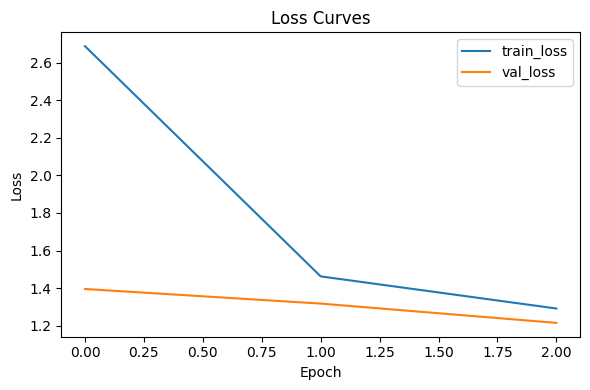

In [5]:
# Plot loss curves
if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")
LossCurvesPlot().render(trained_module, show=True)